# COSC 498: Capstone Project
**Amanda White**

Problem: Predicting stock prices is a complex challenge due to market fluctuations, economic factors, and investor behavior. Many traders, investors, and financial analysts struggle to make informed decisions because they lack accurate predictive tools.
Current methods rely on historical trends, news sentiment, and expert opinions, but these can be subjective and inconsistent. My project leverages machine learning to provide data-driven stock price forecasts, helping users make smarter investment decisions based on historical patterns and technical indicators.

In [2]:
# Step 1: Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Download stock data for Apple (AAPL) from the past 5 years
ticker = "AAPL"
data = yf.download(ticker, start="2019-01-01", end="2024-01-01")

# Save data as CSV
data.to_csv("AAPL_stock_data.csv")

# Display the first few rows
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2019-01-02  37.667183  37.889009  36.787041  36.944466  148158800
2019-01-03  33.915260  34.757238  33.869941  34.342211  365248800
2019-01-04  35.363068  35.432241  34.299268  34.473387  234428400
2019-01-07  35.284359  35.499030  34.800162  35.468021  219111200
2019-01-08  35.956985  36.212204  35.425085  35.673145  164101200


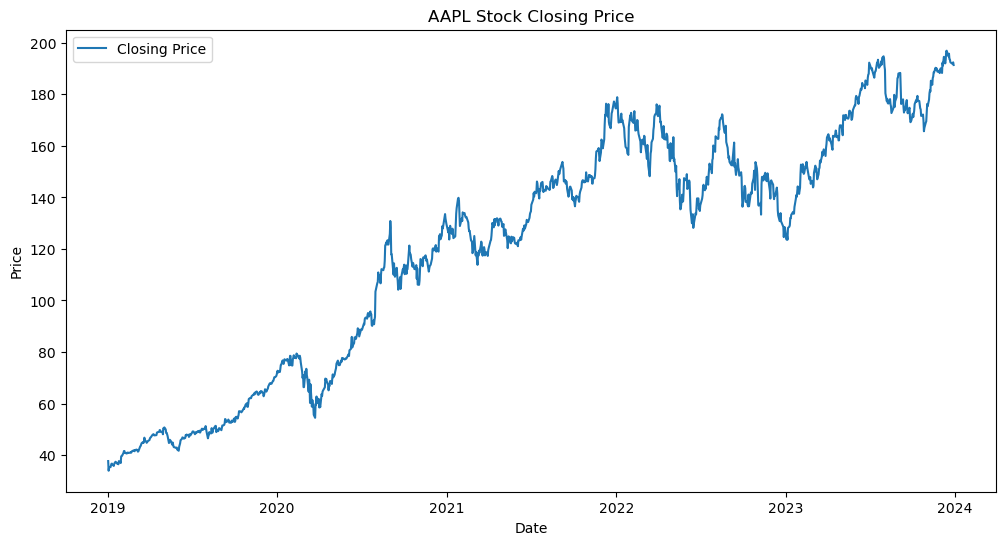

In [4]:
# Historical Trends for past 5 years

# Plot stock closing price
plt.figure(figsize=(12,6))
plt.plot(data["Close"], label="Closing Price")
plt.title(f"{ticker} Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [5]:
# Check for missing data
print(data.isnull().sum())

# If there is missing data forward fill.
data.ffill(inplace=True)

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


In [6]:
# Add Moving Averages (e.g., 50-day and 200-day):
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()


In [7]:
# Add Relative Strength Index (RSI):
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)

In [8]:
# Add previous days' closing prices:
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

In [9]:
# Split 80-20
X = data[['Close', 'MA50', 'MA200', 'RSI', 'Lag_1', 'Lag_2']].dropna()
y = X.pop('Close')  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Normalize features using Min-Max scaling:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
# Train a Linear Regression Model:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lr.predict(X_test_scaled)

# Evaluate performance
print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))


Linear Regression:
MSE: 4.8028197237403685
MAE 1.5804653069907126
R^2: 0.9964587401034088


In [12]:
# Test random forest:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest:")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("MAE", mean_absolute_error(y_test, y_pred_rf))
print("R^2:", r2_score(y_test, y_pred_rf))


C:\Users\amand\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest:
MSE: 4.995460523238636
MAE 1.6297684383392332
R^2: 0.996316700389876


In [13]:
# Prepare Data for LSTM:
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


In [14]:
# Build the LSTM Architecture:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')


In [15]:
# Train the Model:
model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test))


Epoch 1/20
27/27 [==============================] - 8s 40ms/step - loss: 19413.3164 - val_loss: 18530.8047
Epoch 2/20
27/27 [==============================] - 0s 8ms/step - loss: 17793.6797 - val_loss: 16517.6816
Epoch 3/20
27/27 [==============================] - 0s 8ms/step - loss: 16595.3594 - val_loss: 15945.4551
Epoch 4/20
27/27 [==============================] - 0s 8ms/step - loss: 16105.3896 - val_loss: 15520.7783
Epoch 5/20
27/27 [==============================] - 0s 10ms/step - loss: 15701.4619 - val_loss: 15136.5850
Epoch 6/20
27/27 [==============================] - 0s 9ms/step - loss: 15353.1846 - val_loss: 14777.8047
Epoch 7/20
27/27 [==============================] - 0s 9ms/step - loss: 14978.2676 - val_loss: 14433.0723
Epoch 8/20
27/27 [==============================] - 0s 12ms/step - loss: 14656.1172 - val_loss: 14101.3330
Epoch 9/20
27/27 [==============================] - 0s 11ms/step - loss: 14299.6875 - val_loss: 13779.0127
Epoch 10/20
27/27 [=======================

In [16]:
# Evaluate the Model:
y_pred_lstm = model.predict(X_test_lstm)
print("LSTM Model:")
print("MSE:", mean_squared_error(y_test, y_pred_lstm))
print("MAE", mean_absolute_error(y_test, y_pred_lstm))
print("R^2:", r2_score(y_test, y_pred_lstm))

7/7 [==============================] - 1s 3ms/step
LSTM Model:
MSE: 10730.055482428648
MAE 96.82548227849996
R^2: -6.911584726009704


In [17]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Initialize the model and GridSearchCV
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Output best parameters and confirm it runs successfully
grid_search.best_params_

C:\Users\amand\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [26]:
# Fit the model
grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf_model = grid_search.best_estimator_

# Output best parameters
print("Best parameters found:", grid_search.best_params_)

# Evaluate Best Random Forest
best_rf_pred = best_rf_model.predict(X_test)
print("Best Random Forest:")
print("MSE:", mean_squared_error(y_test, best_rf_pred))
print("MAE:", mean_absolute_error(y_test, best_rf_pred))
print("R^2:", r2_score(y_test, best_rf_pred))

C:\Users\amand\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest:
MSE: 4.94779304876673
MAE: 1.6203336424497559
R^2: 0.9963518470173632


In [30]:
# Test all models on unseen data and summarize results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Best Random Forest', 'LSTM'],
    'MSE': [
        mean_squared_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred_rf),
        mean_squared_error(y_test, best_rf_pred),
        mean_squared_error(y_test, y_pred_lstm)
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, best_rf_pred),
        mean_absolute_error(y_test, y_pred_lstm)
    ],
    'R^2': [
        r2_score(y_test, y_pred),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, best_rf_pred),
        r2_score(y_test, y_pred_lstm)
    ]
})

print(results)

                Model           MSE        MAE       R^2
0   Linear Regression      4.802820   1.580465  0.996459
1       Random Forest      4.995461   1.629768  0.996317
2  Best Random Forest      4.947793   1.620334  0.996352
3                LSTM  10730.055482  96.825482 -6.911585


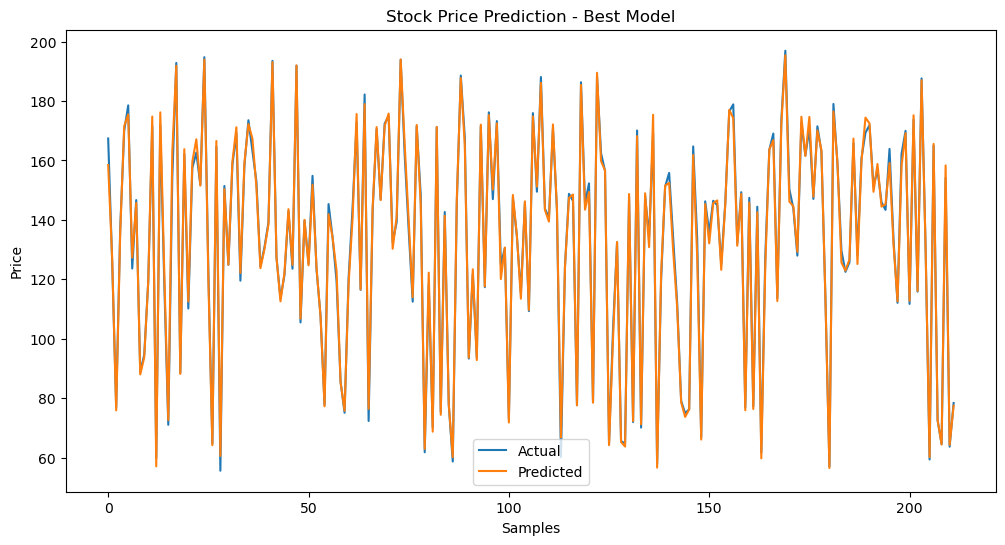

In [38]:
# Plot predictions from the best model
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(best_rf_pred, label='Predicted')
plt.title('Stock Price Prediction - Best Model')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.legend()
plt.show()
